In [31]:
#dependencies
from __future__ import print_function
import datetime as dt
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from matplotlib import style
from coinbase.wallet.client import Client
from statsmodels.sandbox.regression.predstd import wls_prediction_std
%matplotlib inline

style.use('ggplot')

In [32]:
#setting the search parameters
def get_return(tickers, start, end, log_return=True):
    data = web.DataReader(tickers,'yahoo', start, end)['Adj Close']
    data = data.sort_index()
    
    if log_return:
        daily_return = np.log(data.pct_change()+1)
        
    else:
        daily_return = data.pct_change()
        
    daily_return.fillna(0, inplace=True)
    
    return daily_return

In [33]:
start = dt.datetime(2018,1,1)
end = dt.datetime(2018,12,31)

#list of stock in portfolio
tickers = ['AMZN', 'SPY']

In [34]:
daily_return = get_return(tickers, start, end, log_return=True)

In [35]:
daily_return.head()

Symbols,AMZN,SPY
Date,,
2018-01-02,0.000000,0.000000
2018-01-03,0.012694,0.006305
2018-01-04,0.004466,0.004206
2018-01-05,0.016033,0.006642
2018-01-08,0.014322,0.001827


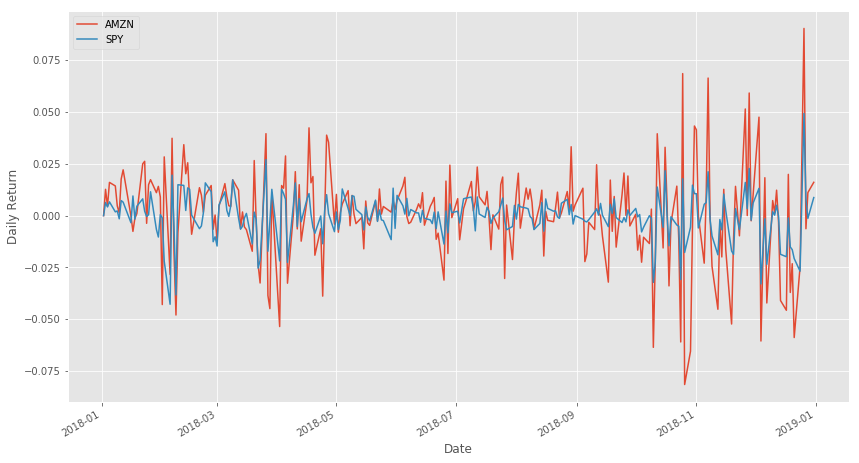

In [36]:
daily_return.plot(figsize=(14,8))
plt.ylabel('Daily Return')
plt.legend()
plt.show()

In [37]:
#Print out stats results  -Will come back to this one later
results = smf.ols('AMZN ~ SPY', data=daily_return).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   AMZN   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     349.0
Date:                Tue, 09 Apr 2019   Prob (F-statistic):           2.82e-49
Time:                        18:23:08   Log-Likelihood:                 703.82
No. Observations:                 251   AIC:                            -1404.
Df Residuals:                     249   BIC:                            -1397.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0013      0.001      1.376      0.1

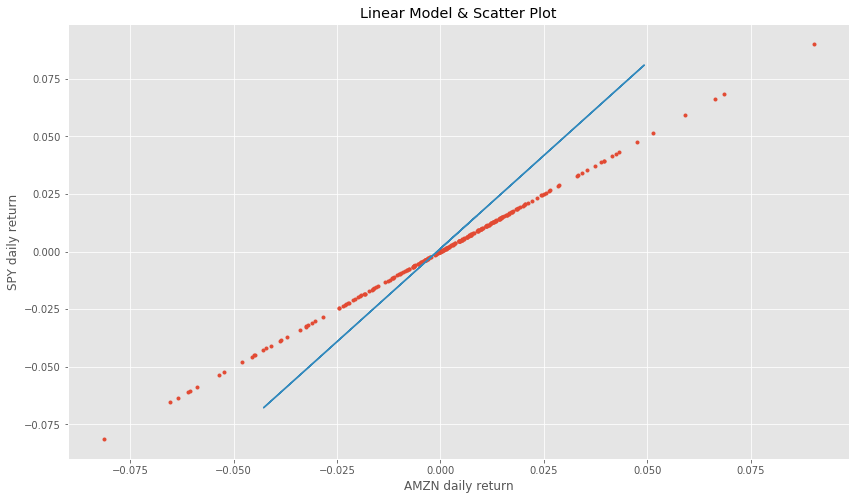

In [49]:
plt.figure(figsize=(14,8))
plt.xlabel('AMZN daily return')
plt.ylabel('SPY daily return')
plt.title('Linear Model & Scatter Plot')
plt.plot(daily_return['AMZN'], daily_return['AMZN'], '.', daily_return['SPY'], results.predict(daily_return['SPY']), '-')

In [40]:
results.params

Intercept    0.001278
SPY          1.617063
dtype: float64

In [41]:
alpha = results.params[0]
beta = results.params[1]
print('alpha:' + str(alpha))
print('beta:' + str(beta))

alpha:0.0012781427359341599
beta:1.6170628524897381


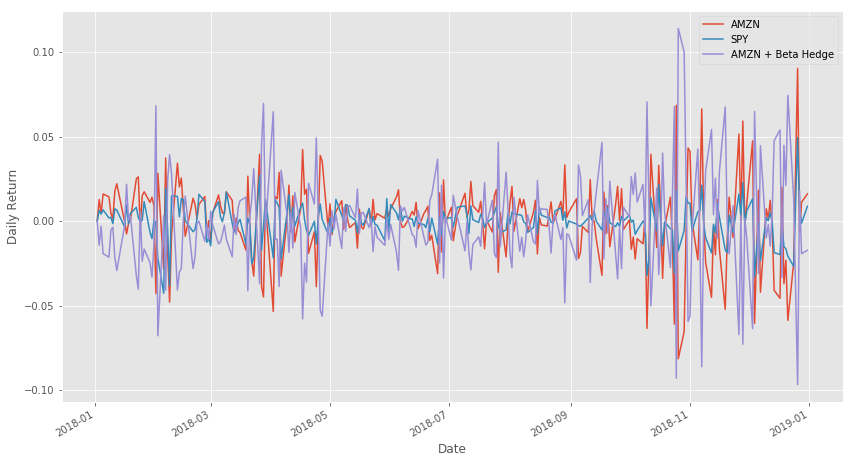

In [44]:
#bulding portfolio with beta hedging
#Alpha = actual return - [Beta(rm-rf)+rf]
#In this case the risk free rate is 0, so Alpha is just the intercet in the
#linear model
#Beta is the hedge ratio, so the hedge is only added to the AMZN return, thus we get the pure Alpha

portfolio = -1*beta*daily_return['AMZN'] + daily_return['SPY']
portfolio.name = "AMZN + Beta Hedge"
daily_return['AMZN'].plot(figsize=(14,8)) 
daily_return['SPY'].plot(figsize=(14,8))
portfolio.plot(figsize=(14,8))
plt.ylabel("Daily Return")
plt.legend()
plt.show()

In [45]:
daily_return['AMZN + Beta Hedge'] = portfolio

In [46]:
daily_return.head()

Symbols,AMZN,SPY,AMZN + Beta Hedge
Date,,,
2018-01-02,0.000000,0.000000,0.000000
2018-01-03,0.012694,0.006305,-0.014222
2018-01-04,0.004466,0.004206,-0.003016
2018-01-05,0.016033,0.006642,-0.019285
2018-01-08,0.014322,0.001827,-0.021332


In [47]:
#use cumprod() function to return the cumulative multiplication results.
cum_daily_return = (1 + daily_return).cumprod()
cum_daily_return.head()

Symbols,AMZN,SPY,AMZN + Beta Hedge
Date,,,
2018-01-02,1.000000,1.000000,1.000000
2018-01-03,1.012694,1.006305,0.985778
2018-01-04,1.017217,1.010538,0.982805
2018-01-05,1.033526,1.017250,0.963851
2018-01-08,1.048328,1.019108,0.943290


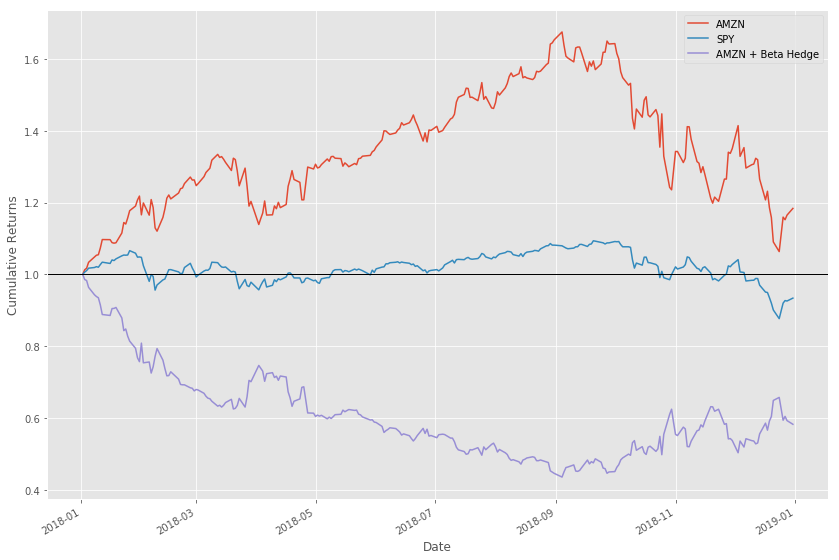

In [48]:
cum_daily_return.plot(grid = True, figsize=(14,10)).axhline(y = 1, color = "black", lw = 1)
plt.ylabel("Cumulative Returns")
plt.legend()
plt.show()